# Test tiger with location scale regression

In [1]:
import jax
import jax.numpy as jnp
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Set path such that interpreter finds tigerpy
import sys
sys.path.append("..")

import tigerpy.model as tiger
import tigerpy.bbvi as bbvi

# Use distributions and bijectors from tensorflow probability
import tensorflow_probability.substrates.jax.distributions as tfjd

rng = np.random.default_rng(42)

## Simulate data

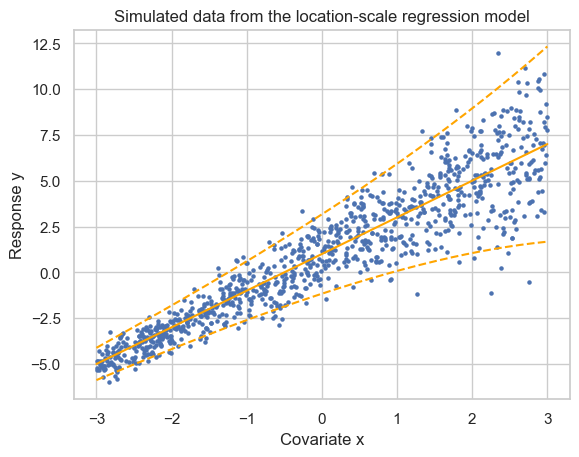

In [2]:
# Sample size and true parameters
n = 1000
true_beta = np.array([1.0, 2.0])
true_gamma = np.array([0.1, 0.3])

# Data-generating process
x0 = rng.uniform(size=n, low=-3, high=3)
X_mat = np.column_stack([np.ones(n), x0])
Z_mat = np.column_stack([np.ones(n), x0])
log_sigma = Z_mat @ true_gamma
sigma = np.exp(log_sigma)
eps = rng.normal(scale=sigma, size=n)
response_vec = X_mat @ true_beta + eps

# Data to plot the linear regression line
x_plot = np.linspace(-3, 3, num=200)
X_plot = np.column_stack([np.ones(200), x_plot])
Z_plot = np.column_stack([np.ones(200), x_plot])
mean_plot =  X_plot @ true_beta
sigma_plot = np.exp(Z_plot @ true_gamma)

# Set the seaborn theme
sns.set_theme(style="whitegrid")

# Plot the simulated data
plt.scatter(x0, response_vec, s = 5)
plt.plot(x_plot, mean_plot, color="orange")
plt.plot(x_plot, mean_plot - 1.96*sigma_plot, color="orange", linestyle="--")
plt.plot(x_plot, mean_plot + 1.96*sigma_plot, color="orange", linestyle="--")
plt.title("Simulated data from the location-scale regression model")
plt.xlabel("Covariate x")
plt.ylabel("Response y")
plt.show()

## Set up model in tigerpy

In [3]:
# Set up design matrix location
X = tiger.Obs(name = "X")
X.fixed(data = x0)

# Set up design matrix scale
Z = tiger.Obs(name = "Z")
Z.fixed(data = x0)

# Set up hyperparameters for the location
beta_loc = tiger.Hyper(0.0, name="beta_loc")
beta_scale = tiger.Hyper(100.0, name="beta_scale")

# Set up parameters for the location
beta_dist = tiger.Dist(tfjd.Normal, loc=beta_loc, scale=beta_scale)
beta = tiger.Param(value=np.array([0.0, 0.0]), distribution=beta_dist, name="beta")

# Set up hyperparameters for the scale
gamma_loc = tiger.Hyper(0.0, name="gamma_loc")
gamma_scale = tiger.Hyper(10.0, name="gamma_scale")

# Set up parameters for the scale
gamma_dist = tiger.Dist(tfjd.Normal, loc=gamma_loc, scale=gamma_scale)
gamma = tiger.Param(value=np.array([0.0, 0.0]), distribution=gamma_dist, name="gamma")

# Set up the linear predictors
lpred_loc = tiger.Lpred(obs=X, beta=beta)
lpred_scale = tiger.Lpred(obs=Z, function=jnp.exp, gamma=gamma)

# Set up response distribution
response_dist = tiger.Dist(tfjd.Normal, loc=lpred_loc, scale=lpred_scale)
m = tiger.Model(response=response_vec, distribution=response_dist)

In [4]:
jnp.sum(m.log_lik)

Array(-8436.268, dtype=float32)

In [5]:
m.log_prior

Array(-17.491264, dtype=float32)

In [6]:
m.log_prob

Array(-8453.759, dtype=float32)

In [7]:
graph = tiger.ModelGraph(model=m)
graph.build_graph()

In [8]:
graph.logprob()

Array(-8453.759, dtype=float32)

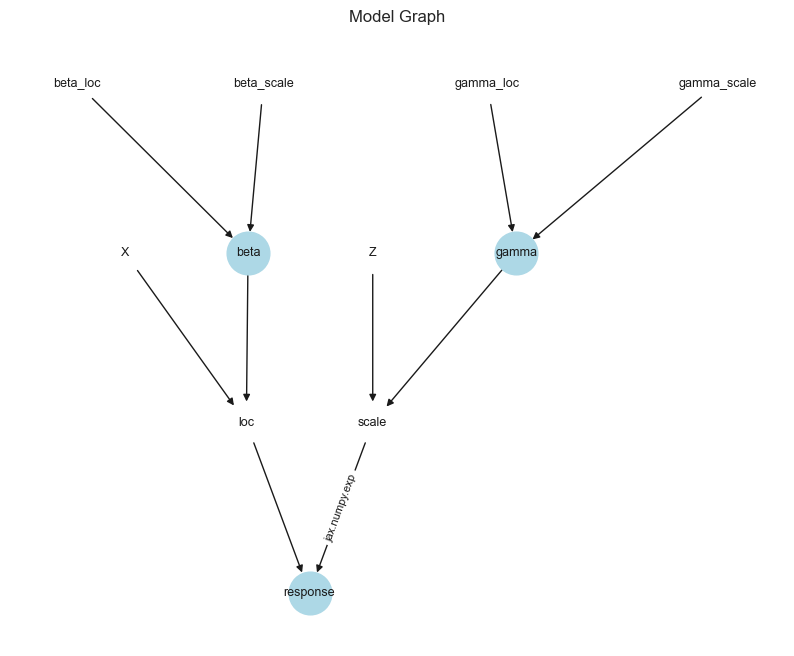

In [9]:
graph.visualize_graph()

## Test Location Scale regression improvements 

In [10]:
import tigerpy.distributions.mvn as mvn
from tigerpy.bbvi.transform import (
    log_cholesky_parametrization_to_tril,
    cov_from_prec_chol
)
from tigerpy.bbvi.init_bbvi import (
    add_jitter
)
from tigerpy.bbvi.control import (
    quadratic_approx_fun, 
    quadratic_approx_mean,
    calc_cv, 
    calc_cv_weight
)

In [11]:
q = bbvi.Bbvi(graph=graph, 
              model_init=True, 
              loc_prec=5.0, 
              scale_prec=5.0)
key = jax.random.PRNGKey(27)
key, *subkeys = jax.random.split(key, 3)

In [13]:
loc_beta, log_chol__prec_beta = q.init_var_params["beta"]["loc"], q.init_var_params["beta"]["log_cholesky_prec"]
loc_gamma, log_chol__prec_gamma = q.init_var_params["gamma"]["loc"], q.init_var_params["gamma"]["log_cholesky_prec"]
lower_tri_beta = log_cholesky_parametrization_to_tril(log_chol__prec_beta, d=loc_beta.shape[0])
lower_tri_gamma = log_cholesky_parametrization_to_tril(log_chol__prec_gamma, d=loc_gamma.shape[0])

In [14]:
noise_beta = mvn.mvn_sample_noise(key=subkeys[0], shape=lower_tri_beta.shape, S=64)
noise_gamma = mvn.mvn_sample_noise(key=subkeys[1], shape=lower_tri_gamma.shape, S=64)
samples_beta = mvn.mvn_precision_chol_sample(loc=loc_beta, precision_matrix_chol=lower_tri_beta, noise=noise_beta)
samples_gamma = mvn.mvn_precision_chol_sample(loc=loc_gamma, precision_matrix_chol=lower_tri_gamma, noise=noise_gamma)

In [15]:
test_samples = {"beta": samples_beta, "gamma": samples_gamma}
test_noise = {"beta": noise_beta, "gamma": noise_gamma}
batch_idx = jax.random.choice(key, n, (256,), replace=False)
data_new = jax.tree_map(lambda x: x[batch_idx], q.data)

In [18]:
q.mc_logprob(data_new, test_samples, q.num_obs)

Array(-2064.768, dtype=float32)

In [30]:
neg_elbo, noise = q.lower_bound(q.init_var_params, 
                                data_new,
                                num_obs=q.num_obs,
                                num_var_samples=1,
                                key=key)
neg_elbo

Array(2978.9856, dtype=float32)

## Inference with BBVI

In [12]:
q = bbvi.Bbvi(graph=graph,
              model_init=True,
              loc_prec=1.0,
              scale_prec=5.0)

In [15]:
q.run_bbvi(step_size=0.01,
           threshold=1e-2,
           key_int=27,
           batch_size=256,
           train_share=0.8,
           num_var_samples=64,
           chunk_size=50,
           epochs=500)

Start optimization ...
Finished optimization.


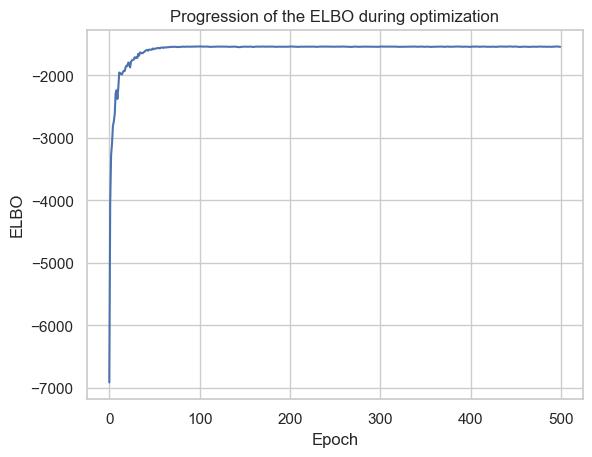

In [16]:
q.plot_elbo()

### Gradient Analysis

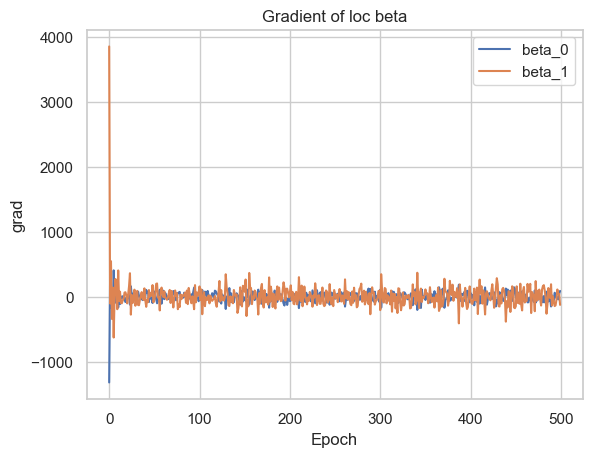

In [17]:
plot_grad_beta_loc = np.vstack([d["beta"]["loc"] for d in q.elbo_hist["grad"]])
plt.plot(q.elbo_hist["epoch"], plot_grad_beta_loc[:,0], label="beta_0")
plt.plot(q.elbo_hist["epoch"], plot_grad_beta_loc[:,1], label="beta_1")
plt.title("Gradient of loc beta")
plt.xlabel("Epoch")
plt.ylabel("grad")
plt.legend()
plt.show()

In [18]:
# Std beta loc batch_size=36, var_samples=64
print(194.33865, 417.29352)
# Std beta loc batch_size=256, var_samples=64
print(66.313286, 132.52414)

194.33865 417.29352
66.313286 132.52414


In [19]:
np.std(plot_grad_beta_loc, axis=0)

array([ 89.44477, 215.53976], dtype=float32)

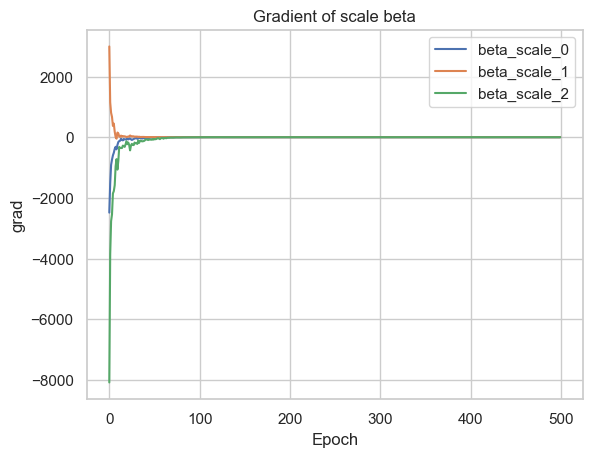

In [20]:
plot_grad_beta_scale = np.vstack([d["beta"]["log_cholesky_prec"] for d in q.elbo_hist["grad"]])
plt.plot(q.elbo_hist["epoch"], plot_grad_beta_scale[:,0], label="beta_scale_0")
plt.plot(q.elbo_hist["epoch"], plot_grad_beta_scale[:,1], label="beta_scale_1")
plt.plot(q.elbo_hist["epoch"], plot_grad_beta_scale[:,2], label="beta_scale_2")
plt.title("Gradient of scale beta")
plt.xlabel("Epoch")
plt.ylabel("grad")
plt.legend()
plt.show()

In [50]:
# Std beta scale batch-size=36, var_samples=64
print(0.96501, 0.04636011, 1.8470832)
# Std beta scale batch-size=256, var_samples=10
print(1.487761, 0.17432383, 5.91412)

0.96501 0.04636011 1.8470832
1.487761 0.17432383 5.91412


In [51]:
np.std(plot_grad_beta_scale, axis=0)

array([132.51607, 191.49925, 576.36884], dtype=float32)

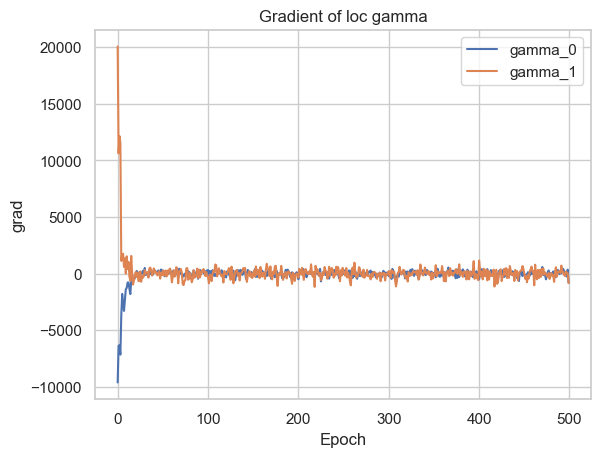

In [52]:
plot_grad_gamma_loc = np.vstack([d["gamma"]["loc"] for d in q.elbo_hist["grad"]])
plt.plot(q.elbo_hist["epoch"], plot_grad_gamma_loc[:,0], label="gamma_0")
plt.plot(q.elbo_hist["epoch"], plot_grad_gamma_loc[:,1], label="gamma_1")
plt.title("Gradient of loc gamma")
plt.xlabel("Epoch")
plt.ylabel("grad")
plt.legend()
plt.show()

In [53]:
# Std gamma loc batch_size=36, var_samples=10
print(266.23312, 449.4615)
# std gamma loc batch_size=256, var_samples=10
print(75.7966, 133.12659)

266.23312 449.4615
75.7966 133.12659


In [54]:
np.std(plot_grad_gamma_loc, axis=0)


array([ 766.4233, 1325.2173], dtype=float32)

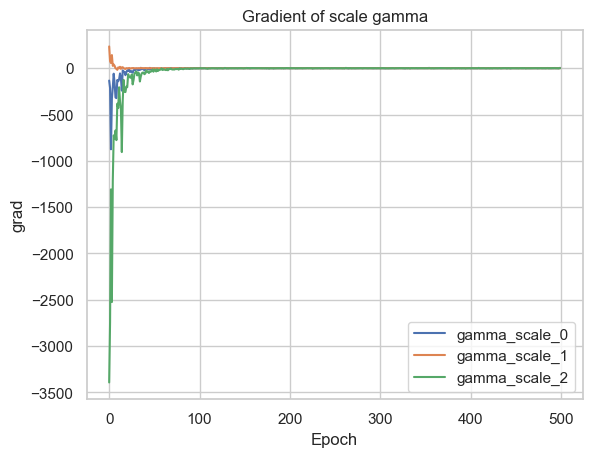

In [55]:
plot_grad_gamma_scale = np.vstack([d["gamma"]["log_cholesky_prec"] for d in q.elbo_hist["grad"]])
plt.plot(q.elbo_hist["epoch"], plot_grad_gamma_scale[:,0], label="gamma_scale_0")
plt.plot(q.elbo_hist["epoch"], plot_grad_gamma_scale[:,1], label="gamma_scale_1")
plt.plot(q.elbo_hist["epoch"], plot_grad_gamma_scale[:,2], label="gamma_scale_2")
plt.title("Gradient of scale gamma")
plt.xlabel("Epoch")
plt.ylabel("grad")
plt.legend()
plt.show()

In [56]:
# Std gamma scale batch_size=36
print(1.1206654, 0.01489894, 1.8439218)
# Std gamma scale batch_size=256
print(2.4510572, 0.04107023, 8.883321)

1.1206654 0.01489894 1.8439218
2.4510572 0.04107023 8.883321


In [57]:
np.std(plot_grad_gamma_scale, axis=0)

array([ 51.497486,  13.212513, 252.67918 ], dtype=float32)

In [58]:
q.trans_var_params

{'beta': {'loc': Array([0.92950666, 2.0104313 ], dtype=float32),
  'cov': Array([[7.9687597e-04, 2.0262807e-05],
         [2.0262807e-05, 2.0129514e-04]], dtype=float32)},
 'gamma': {'loc': Array([0.10131101, 0.27640298], dtype=float32),
  'cov': Array([[4.9116055e-04, 3.1576690e-07],
         [3.1576687e-07, 1.6566584e-04]], dtype=float32)}}